In [18]:
import logging
import torch
import data 

from models import imagebind_model
from models.imagebind_model import ModalityType, load_module
from models import lora as LoRA

logging.basicConfig(level=logging.INFO, force=True)

/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [1]:
from torchvision import transforms
from torchvision.transforms._transforms_video import NormalizeVideo

from pytorchvideo import transforms as pv_transforms
from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler
from pytorchvideo.data.encoded_video import EncodedVideo

import pandas as pd
import numpy as np
import os
import re

from  sklearn import metrics
import pickle

/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
from tqdm import tqdm

## Init ImageBind model

In [21]:
def get_clip_timepoints(clip_sampler, duration):
    # Read out all clips in this video
    all_clips_timepoints = []
    is_last_clip = False
    end = 0.0
    while not is_last_clip:
        start, end, _, _, is_last_clip = clip_sampler(end, duration, annotation=None)
        all_clips_timepoints.append((start, end))
    return all_clips_timepoints


def load_and_transform_video_data_inference(
    video_paths,
    device,
    clip_duration=1,
    clips_per_video=5, # default 5, I used for train 4
    sample_rate=16000,
):

    if video_paths is None:
        return None

    video_outputs = []
    video_transform = transforms.Compose(
        [
            pv_transforms.ShortSideScale(224),
            NormalizeVideo(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )

    clip_sampler = ConstantClipsPerVideoSampler(
        clip_duration=clip_duration, clips_per_video=clips_per_video
    )
    frame_sampler = pv_transforms.UniformTemporalSubsample(num_samples=clip_duration)

    for video_path in video_paths:
        video = EncodedVideo.from_path(
            video_path,
            # decoder="decord",
            decode_audio=False,
            # **{"sample_rate": sample_rate},
        )

        all_clips_timepoints = get_clip_timepoints(clip_sampler, video.duration)

        all_video = []
        for clip_timepoints in all_clips_timepoints:
            # Read the clip, get frames
            clip = video.get_clip(clip_timepoints[0], clip_timepoints[1])
            if clip is None:
                raise ValueError("No clip found")
            video_clip = frame_sampler(clip["video"])
            video_clip = video_clip / 255.0  # since this is float, need 0-1

            all_video.append(video_clip)

        all_video = [video_transform(clip) for clip in all_video]
        all_video = data.SpatialCrop(224, num_crops=3)(all_video) # default num_crops=3, used for train 1

        all_video = torch.stack(all_video, dim=0)
        video_outputs.append(all_video)
    video_tensor = torch.stack(video_outputs, dim=0).to(device)
    return video_tensor


# def load_imu_inference(imu_paths, device):
#     imus = []
#     for imu_path in imu_paths:
#         event = pd.read_csv(imu_path)
#         imu_seq = event[['vx','vy','v','ax','ay','a']].values
#         imu_seq = imu_seq[:2000].T.astype('float32')
#         imu_tensor = torch.from_numpy(imu_seq)
#         imus.append(imu_tensor)
#     imus_tensor = torch.stack(imus, dim=0).to(device)
#     return imus_tensor


In [22]:
lora = True
linear_probing = False
device = "cpu"  # "cuda:0" if torch.cuda.is_available() else "cpu"
load_head_post_proc_finetuned = True

assert not (linear_probing and lora), \
            "Linear probing is a subset of LoRA training procedure for ImageBind. " \
            "Cannot set both linear_probing=True and lora=True. "

if lora and not load_head_post_proc_finetuned:
    # Hack: adjust lora_factor to the `max batch size used during training / temperature` to compensate missing norm
    lora_factor = 12 / 0.07
else:
    # This assumes proper loading of all params but results in shift from original dist in case of LoRA
    lora_factor = 1

lora_factor

1

In [23]:
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
if lora:
    model.modality_trunks.update(
        LoRA.apply_lora_modality_trunks(model.modality_trunks, rank=4,
                                        modality_names=[ModalityType.VISION, ModalityType.IMU]))

    # Load LoRA params if found
    LoRA.load_lora_modality_trunks(model.modality_trunks,
                                   checkpoint_dir=".checkpoints/lora/550_epochs_lora", postfix="_dreambooth_last")

    if load_head_post_proc_finetuned:
        # Load postprocessors & heads
        load_module(model.modality_postprocessors, module_name="postprocessors",
                    checkpoint_dir=".checkpoints/lora/550_epochs_lora", postfix="_dreambooth_last")
        load_module(model.modality_heads, module_name="heads",
                    checkpoint_dir=".checkpoints/lora/550_epochs_lora", postfix="_dreambooth_last")

model.eval()
# model.to(device)

INFO:root:Loaded LoRA parameters for modality vision from .checkpoints/lora/550_epochs_lora.
INFO:root:Loaded parameters for module postprocessors from .checkpoints/lora/550_epochs_lora.
INFO:root:Loaded parameters for module heads from .checkpoints/lora/550_epochs_lora.


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [8]:
# storage
base = '/home/vash/apps/avatar/avatar_studio/db'
video = 'C9180/videos/talk01.mp4'

In [9]:
# Load data
device = 'cpu'

video_path = os.path.join(base, video)
# imu_path = '/home/vashloc/apps/ImageBindLora/ImageBind-LoRA/.datasets/RBLeipzig-WerderBremen_14052023_1T/RB2/telemetry/1_0_199_448.csv'

v = load_and_transform_video_data_inference([video_path, video_path], device)
# imu = load_imu_inference([imu_path, imu_path], device)

v.shape  #, imu.shape

torch.Size([2, 15, 3, 1, 224, 224])

## Gert embs for avatar video

In [107]:
device = 'cuda'
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [11]:
df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')
df.head()

,folder,video_type,duration,path,vcls
0,C9180,talk01,4.56,C9180/videos/talk01.mp4,talk
1,C9180,talk02,3.80,C9180/videos/talk02.mp4,talk
2,C9180,talk03,5.16,C9180/videos/talk03.mp4,talk
3,C9180,talk04,2.08,C9180/videos/talk04.mp4,talk
4,C9180,talk05,2.40,C9180/videos/talk05.mp4,talk


In [12]:
df.shape

(328, 5)

In [13]:
df.vcls.value_counts()

vcls
talk                      142
talk_neutral_              46
talk_happy_                26
general_                   25
talk_persuasive_           14
talk_interrogative_        13
affirmative_               12
talk_sorry_                 8
negative_                   8
pause                       8
talking_happy_              5
talking_neutral_            5
talking_sorry_              3
talking_interrogative_      3
talking_persuasive_         2
helpless_                   1
ok_                         1
cross                       1
hands                       1
dance_                      1
yes_                        1
shy_                        1
sorry_                      1
Name: count, dtype: int64

In [14]:
embs = []
labels = []

for i, r in tqdm(df.iterrows()):
    video_paths = [os.path.join(base, r.path)]
    
    if os.path.exists(video_paths[0]):
        try:
            inputs = {
            
                ModalityType.VISION: load_and_transform_video_data_inference(video_paths, device),
            }

            with torch.no_grad():
                embeddings = model(inputs)
            
            embs.append(embeddings['vision'].cpu().numpy())
            labels.append(r.path)
        except:
            print(f'Some problem with: {r.path}')

embs = np.vstack(embs)
embs.shape

328it [1:04:55, 11.88s/it]


(326, 1024)

In [18]:
with open('avatar_embs.npy', 'wb') as f:
    np.save(f, embs)

In [19]:
with open('avatar_labels.pickl', 'wb') as f:
    pickle.dump(labels, f)

In [20]:
assert len(embs) == len(labels)

## Build clusters

In [9]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
from tqdm import tqdm

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
import umap  # umap-learn==0.5.3
from distinctipy import distinctipy   # distinctipy==1.2.2
import matplotlib.pyplot as plt
import cv2

/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/

In [32]:
from projector import projector

In [7]:
df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')
df.shape

(328, 5)

In [8]:
df.head()

,folder,video_type,duration,path,vcls
0,C9180,talk01,4.56,C9180/videos/talk01.mp4,talk
1,C9180,talk02,3.80,C9180/videos/talk02.mp4,talk
2,C9180,talk03,5.16,C9180/videos/talk03.mp4,talk
3,C9180,talk04,2.08,C9180/videos/talk04.mp4,talk
4,C9180,talk05,2.40,C9180/videos/talk05.mp4,talk


In [9]:
with open('avatar_embs.npy', 'rb') as f:
    EMBS = np.load(f)

with open('avatar_labels.pickl', 'rb') as f:
    labels = pickle.load(f)

EMBS.shape, len(labels)

((326, 1024), 326)

In [10]:
# Some videos from avatar dataset were broken, that why we need to sync videos and embs 

ds = pd.DataFrame()
ds['path'] = labels
ds = ds.merge(df, on='path', how='left')
ds.shape

(326, 5)

In [11]:
ds.head()

,path,folder,video_type,duration,vcls
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk


In [37]:
# Resize images for cluster visualization in bokeh
base = '/home/vash/apps/avatar/avatar_studio/db'

imgs = []
for i in tqdm(labels):
    video_path = os.path.join(base, i)
    cap = cv2.VideoCapture(video_path)
    while(cap.isOpened()):
        ret,img = cap.read()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        break
    imgs.append(img)
    cap.release()

with open('imgs.pckl', 'wb') as f:
    pickle.dump(imgs, f)

100%|██████████| 326/326 [00:33<00:00,  9.77it/s]


In [38]:
_labels = ds.vcls.values
_labels[:3]

array(['talk', 'talk', 'talk'], dtype=object)

In [39]:
# k = 5000
thumb_size = 96
plot_size = 800

# bokeh umap visualization
projector(EMBS, labels=_labels, images=imgs, image_size=thumb_size, plot_size=plot_size, save_file=True)

perfoming projection using UMAP


generating diplayabe images: 100%|██████████| 326/326 [00:00<00:00, 1766.93it/s]


Loading BokehJS ...

In [31]:
reducer = umap.UMAP(densmap=True)
cords = reducer.fit_transform(EMBS)
_idxs = list(range(len(EMBS)))

class_list = sorted(set(_labels))
num_classes = len(class_list)

# generate data
data = dict(
    id=_idxs,
    x=[i[0] for i in cords],
    y=[i[1] for i in cords],
    labels=_labels,
)

data = pd.DataFrame.from_dict(data)

<Axes: xlabel='x', ylabel='y'>

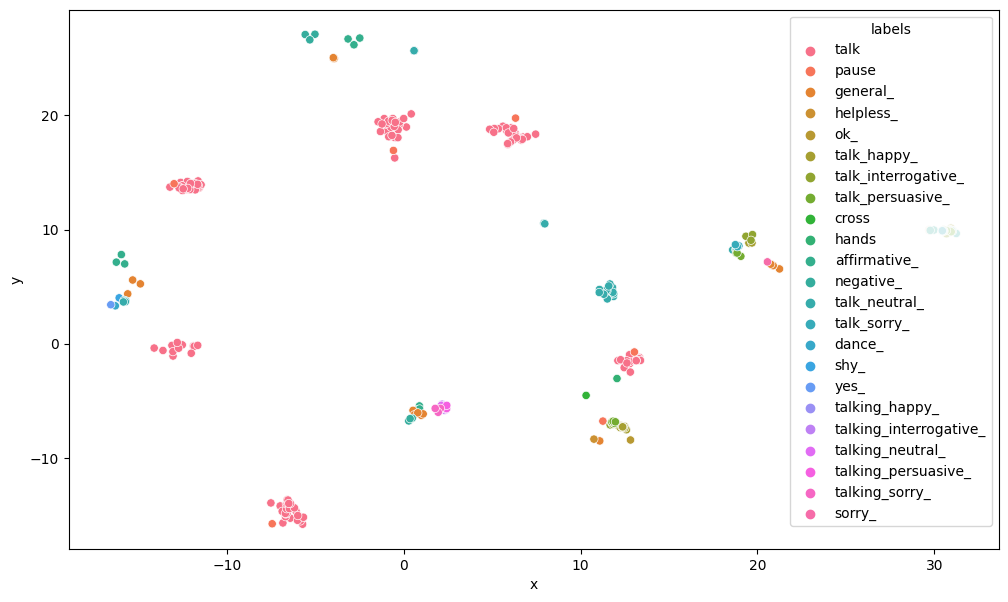

In [36]:
fig = plt.figure(figsize=(12, 7))
sns.scatterplot(data, x='x', y='y', hue='labels')

## Text modality for eacvh video class

In [7]:
import re

In [22]:
ds.head()

,path,folder,video_type,duration,vcls
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk


In [141]:
def preproc_text_labels(ds):
    
    gender_map = {
              'Arvid': 'man', 
              'Bizdev': 'man',
              'C9175': 'man',
              'C9176': 'woman',
              'C9180': 'woman',
              'C9183': 'man',
              'C9186': 'man',
              'C9187': 'woman',
              'C9188': 'man',
              'Jessica': 'woman',
              'Mia': 'woman',
              'Nick': 'man',
              'Vlad': 'man',
              'Yao': 'man',
              }
    
    ds['gender'] = ds.folder.apply(lambda x: gender_map[x])
    ds['vcls'] = ds.vcls.apply(lambda x: x.replace('_', ' ').strip())
    ds['vcls'] = ds.vcls.apply(lambda x: re.sub('talk ', 'talking ', x))
    ds.loc[ds.vcls == 'pause', 'vcls'] = 'talk pause'
    ds.loc[ds.vcls == 'yes', 'vcls'] = 'agreement'
    ds.loc[ds.vcls == 'ok', 'vcls'] = 'agreement'

    def get_sentence(r):
        return f"{r[0]} {r[1]}"
    
    ds['sentence'] = ds[['gender', 'vcls']].apply(get_sentence, axis=1)
    return ds


In [23]:
gender_map = {
              'Arvid': 'man', 
              'Bizdev': 'man',
              'C9175': 'man',
              'C9176': 'woman',
              'C9180': 'woman',
              'C9183': 'man',
              'C9186': 'man',
              'C9187': 'woman',
              'C9188': 'man',
              'Jessica': 'woman',
              'Mia': 'woman',
              'Nick': 'man',
              'Vlad': 'man',
              'Yao': 'man',
              }

ds['gender'] = ds.folder.apply(lambda x: gender_map[x])
ds.head(3)

,path,folder,video_type,duration,vcls,gender
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman


In [24]:
ds['vcls'] = ds.vcls.apply(lambda x: x.replace('_', ' ').strip())

In [25]:
ds['vcls'] = ds.vcls.apply(lambda x: re.sub('talk ', 'talking ', x))

In [26]:
ds.loc[ds.vcls == 'pause', 'vcls'] = 'talk pause'
ds.loc[ds.vcls == 'yes', 'vcls'] = 'agreement'
ds.loc[ds.vcls == 'ok', 'vcls'] = 'agreement'

In [27]:
ds.vcls.value_counts()

vcls
talk                     142
talking neutral           51
talking happy             30
general                   25
talking interrogative     16
talking persuasive        16
affirmative               12
talking sorry             11
negative                   8
talk pause                 7
agreement                  2
shy                        1
dance                      1
cross                      1
hands                      1
helpless                   1
sorry                      1
Name: count, dtype: int64

In [28]:
def get_sentence(r):
    return f"{r[0]} {r[1]}"

In [29]:
ds['sentence'] = ds[['gender', 'vcls']].apply(get_sentence, axis=1)

In [30]:
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


In [110]:
# Get embeddings for text modality
text_embs = []
sentences = []

for i in tqdm(ds.sentence.unique()):
    text_list = [i]
    
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    }

    with torch.no_grad():
        embeddings = model(inputs)
    
    text_embs.append(embeddings['text'].cpu().numpy())
    sentences.append(i)


text_embs = np.vstack(text_embs)
text_embs.shape

100%|██████████| 28/28 [00:01<00:00, 15.00it/s]


(28, 1024)

In [112]:
with open('avatar_text_embs.npy', 'wb') as f:
    np.save(f, text_embs)

with open('avatar_sentences.pickl', 'wb') as f:
    pickle.dump(sentences, f)

In [ ]:
# To do: compare text and video vectors

In [31]:
with open('avatar_text_embs.npy', 'rb') as f:
    text_embs = np.load(f)

text_embs.shape

(28, 1024)

In [32]:
with open('avatar_sentences.pickl', 'rb') as f:
    sentences = pickle.load(f)

['woman talk', 'woman talk pause', 'man general']

In [ ]:
embs.sah

## Compare text and video vectors

In [71]:
# Videos
with open('avatar_embs.npy', 'rb') as f:
    EMBS = np.load(f)

with open('avatar_labels.pickl', 'rb') as f:
    labels = pickle.load(f)

EMBS.shape, len(labels)

((326, 1024), 326)

In [72]:
# Some videos from avatar dataset were broken, that why we need to sync videos and embs 

df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')

ds = pd.DataFrame()
ds['path'] = labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


In [77]:
ds.duration.describe()

count    326.000000
mean       6.153252
std        3.532194
min        0.840000
25%        3.200000
50%        5.460000
75%        8.840000
max       16.320000
Name: duration, dtype: float64

In [78]:
ds[ds.duration < 1]

,path,folder,video_type,duration,vcls,gender,sentence
81,C9175/videos/talk30.mp4,C9175,talk30,0.96,talk,man,man talk
271,Jessica/videos/yes_01.mp4,Jessica,yes_01,0.84,agreement,woman,woman agreement


<Axes: >

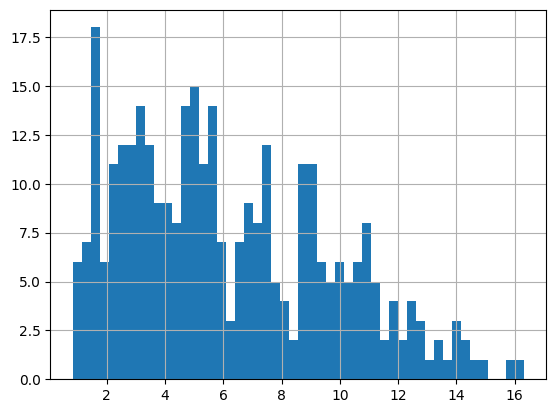

In [76]:
ds.duration.hist(bins=50)

In [8]:
ds.shape

(326, 7)

In [41]:
# Text vectors

with open('avatar_text_embs.npy', 'rb') as f:
    text_embs = np.load(f)

with open('avatar_sentences.pickl', 'rb') as f:
    sentences = pickle.load(f)

text_embs.shape, len(sentences), sentences[:3]

((28, 1024), 28, ['woman talk', 'woman talk pause', 'man general'])

In [57]:
D = metrics.pairwise_distances(text_embs, EMBS, metric='cosine')
D.shape

(28, 326)

In [75]:
print(f'Search video by text')

k = 7

for i in range(len(text_embs)):
    m = D[i]
    topk_ids = m.argsort()[:k]
    scores = m[topk_ids]
    video_labels_df = ds.iloc[topk_ids]
    
    video_ids = None
    print(f'Query: {sentences[i]}, Videos: {video_labels_df.sentence.values.tolist()}')

Search video by text
Query: woman talk, Videos: ['woman general', 'woman general', 'woman affirmative', 'woman general', 'woman negative', 'woman affirmative', 'woman negative']
Query: woman talk pause, Videos: ['woman general', 'woman cross', 'woman general', 'woman negative', 'woman affirmative', 'woman negative', 'woman negative']
Query: man general, Videos: ['man talking neutral', 'man talking neutral', 'man talking neutral', 'man talking neutral', 'man talking neutral', 'man talking neutral', 'man talking neutral']
Query: man helpless, Videos: ['man talk', 'man talk', 'man talk', 'man talk', 'man affirmative', 'man talk', 'man talk']
Query: man agreement, Videos: ['man general', 'man general', 'man general', 'man general', 'man negative', 'man talking neutral', 'man talking neutral']
Query: man talk pause, Videos: ['man talk pause', 'man general', 'man talk', 'man talk', 'man general', 'man talk', 'man talk']
Query: man talking happy, Videos: ['man general', 'man general', 'man ge

## Key points (torch)

In [10]:
from torchvision.io import ImageReadMode
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

In [11]:
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

In [12]:
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

In [14]:
from torchvision.io import read_image

In [15]:
img_path = '/home/vash/apps/avatar/avatar_studio/db/Arvid/reference_frame.png'
img = read_image(img_path)
img_norm = transforms(img)

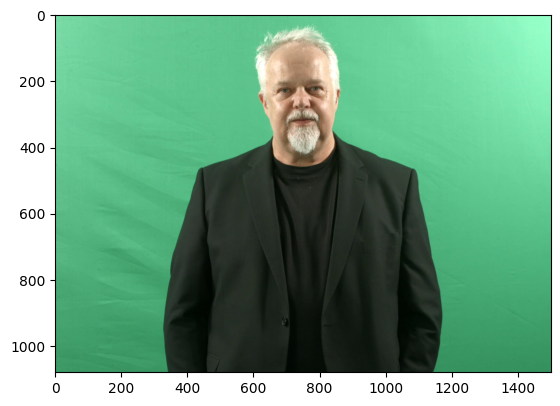

In [95]:
plt.imshow(torch.permute(img, (1,2,0)))

In [96]:
outputs = model([img_norm])
print(outputs)

[{'boxes': tensor([[ 307.8880,   57.5379, 1180.1008, 1057.6553]],
       grad_fn=<StackBackward0>), 'labels': tensor([1]), 'scores': tensor([0.9999], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[7.4534e+02, 2.6499e+02, 1.0000e+00],
         [7.8848e+02, 2.1904e+02, 1.0000e+00],
         [6.9546e+02, 2.2850e+02, 1.0000e+00],
         [8.5049e+02, 2.5148e+02, 1.0000e+00],
         [6.3480e+02, 2.6905e+02, 1.0000e+00],
         [1.0325e+03, 5.1638e+02, 1.0000e+00],
         [4.8112e+02, 5.1908e+02, 1.0000e+00],
         [1.1039e+03, 8.7993e+02, 1.0000e+00],
         [3.8945e+02, 8.9345e+02, 1.0000e+00],
         [1.0945e+03, 1.0543e+03, 1.0000e+00],
         [3.9349e+02, 1.0543e+03, 1.0000e+00],
         [9.2599e+02, 1.0543e+03, 1.0000e+00],
         [5.5122e+02, 1.0543e+03, 1.0000e+00],
         [9.2733e+02, 1.0543e+03, 1.0000e+00],
         [5.3100e+02, 1.0543e+03, 1.0000e+00],
         [9.4621e+02, 1.0543e+03, 1.0000e+00],
         [5.4313e+02, 1.0543e+03, 1.0000e+00]]], grad_fn=<

In [97]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[7.4534e+02, 2.6499e+02, 1.0000e+00],
         [7.8848e+02, 2.1904e+02, 1.0000e+00],
         [6.9546e+02, 2.2850e+02, 1.0000e+00],
         [8.5049e+02, 2.5148e+02, 1.0000e+00],
         [6.3480e+02, 2.6905e+02, 1.0000e+00],
         [1.0325e+03, 5.1638e+02, 1.0000e+00],
         [4.8112e+02, 5.1908e+02, 1.0000e+00],
         [1.1039e+03, 8.7993e+02, 1.0000e+00],
         [3.8945e+02, 8.9345e+02, 1.0000e+00],
         [1.0945e+03, 1.0543e+03, 1.0000e+00],
         [3.9349e+02, 1.0543e+03, 1.0000e+00],
         [9.2599e+02, 1.0543e+03, 1.0000e+00],
         [5.5122e+02, 1.0543e+03, 1.0000e+00],
         [9.2733e+02, 1.0543e+03, 1.0000e+00],
         [5.3100e+02, 1.0543e+03, 1.0000e+00],
         [9.4621e+02, 1.0543e+03, 1.0000e+00],
         [5.4313e+02, 1.0543e+03, 1.0000e+00]]], grad_fn=<CopySlices>)
tensor([0.9999], grad_fn=<IndexBackward0>)


In [98]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[7.4534e+02, 2.6499e+02, 1.0000e+00],
         [7.8848e+02, 2.1904e+02, 1.0000e+00],
         [6.9546e+02, 2.2850e+02, 1.0000e+00],
         [8.5049e+02, 2.5148e+02, 1.0000e+00],
         [6.3480e+02, 2.6905e+02, 1.0000e+00],
         [1.0325e+03, 5.1638e+02, 1.0000e+00],
         [4.8112e+02, 5.1908e+02, 1.0000e+00],
         [1.1039e+03, 8.7993e+02, 1.0000e+00],
         [3.8945e+02, 8.9345e+02, 1.0000e+00],
         [1.0945e+03, 1.0543e+03, 1.0000e+00],
         [3.9349e+02, 1.0543e+03, 1.0000e+00],
         [9.2599e+02, 1.0543e+03, 1.0000e+00],
         [5.5122e+02, 1.0543e+03, 1.0000e+00],
         [9.2733e+02, 1.0543e+03, 1.0000e+00],
         [5.3100e+02, 1.0543e+03, 1.0000e+00],
         [9.4621e+02, 1.0543e+03, 1.0000e+00],
         [5.4313e+02, 1.0543e+03, 1.0000e+00]]], grad_fn=<IndexBackward0>)


In [15]:
import torchvision.transforms.functional as F

In [100]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

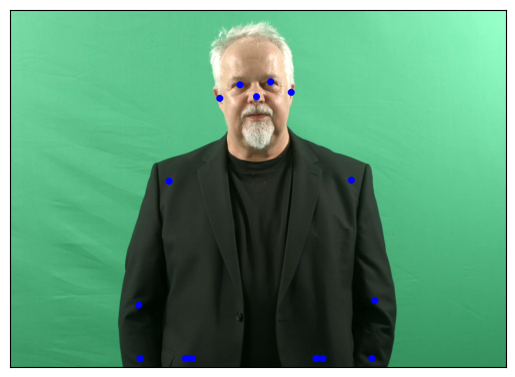

In [102]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(img, keypoints, colors="blue", radius=10)
show(res)

In [38]:
img.shape

torch.Size([3, 1080, 1500])

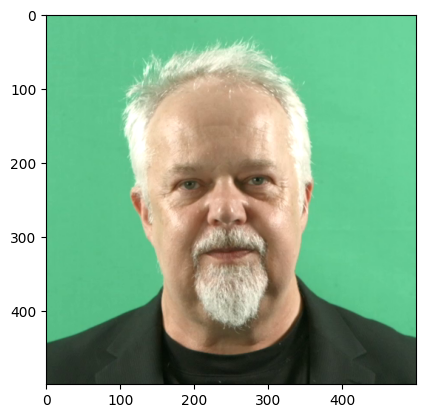

In [39]:
# test

head = img[:, :500, 500: 1000]
plt.imshow(torch.permute(head, (1,2,0)))


In [40]:
transforms(head).shape

torch.Size([3, 500, 500])

In [126]:
head_outputs = model([transforms(head)])

In [127]:
head_outputs[0]['keypoints']

tensor([[[245.8091, 266.3576,   1.0000],
         [287.6761, 221.3811,   1.0000],
         [195.8187, 228.2525,   1.0000],
         [348.2895, 253.2395,   1.0000],
         [137.7048, 267.6070,   1.0000],
         [472.6406, 468.1271,   1.0000],
         [ 77.7163, 491.8647,   1.0000],
         [489.5124, 491.8647,   1.0000],
         [ 22.1020, 491.8647,   1.0000],
         [489.5124, 491.8647,   1.0000],
         [ 22.1020, 491.8647,   1.0000],
         [489.5124, 491.8647,   1.0000],
         [ 22.1020, 491.8647,   1.0000],
         [489.5124, 491.8647,   1.0000],
         [ 22.1020, 491.8647,   1.0000],
         [290.1756, 218.2578,   1.0000],
         [196.4436, 471.2505,   1.0000]]], grad_fn=<CopySlices>)

In [129]:
outputs[0]['keypoints_scores']

tensor([[18.4995, 19.7636, 18.9610, 17.9150, 15.0878, 11.3048, 11.0748,  8.6509,
         10.9216,  4.0452,  2.7041,  2.2461,  1.5830, -5.3725, -4.2782, -4.3042,
         -4.0718]], grad_fn=<CopySlices>)

In [117]:
len(keypoint_names)

17

In [118]:
{k:v for k,v in zip(keypoint_names, head_outputs[0]['scores'])}

{'nose': tensor(0.9968, grad_fn=<UnbindBackward0>)}

### Collect key points info from dataset video

In [13]:
keypoint_names = weights.meta["keypoint_names"]
keypoint_names

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']

In [14]:
base = '/home/vash/apps/avatar/avatar_studio/db'
model.to('cuda')

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
# detect_threshold = 0.75

scale = 1.7
points = []
batch_size = 16


scale_h = 480
scale_w = 640


for i, r in tqdm(ds.iterrows()):
    video_path = os.path.join(base, r.path)
    
    # video_points = []
    
    if os.path.exists(video_path):

        cap = cv2.VideoCapture(video_path)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f'{r.path}, frames: {length}')
        frame_id = 0
        batch = []
        while(cap.isOpened()):
            ret,img = cap.read()
            if ret:
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

                # h, w, _ = img.shape
                # scale_h = int(h / scale)
                # scale_w = int(w / scale)

                img = cv2.resize(img, (scale_w, scale_h))
                img = torch.from_numpy(img).permute(2,0,1)
                img_norm = transforms(img)
                
                if len(batch) < batch_size:
                    batch.append(img_norm)
                else:
                    if frame_id == 0:
                        print(batch[0].shape)
                    with torch.no_grad():
                        batch = torch.stack(batch)
                        outputs = model(batch.to('cuda'))
                        batch = []


                        for b in outputs:
                            
                            kpts = b['keypoints'][0].cpu().numpy()
                            scores = b['keypoints_scores'][0].cpu().numpy()

                            for p, s, n in zip(kpts, scores, keypoint_names):
                                row = {'video': r.path, 'frame_id': frame_id, 'point': n, 'x': p[0], 'y': p[1],  'score': s, 'height': scale_h, 'width': scale_w}
                                points.append(row)
                            
                            frame_id += 1
                    # print(f'Frame: {frame_id}')
            else:
                break

        if len(batch):
            with torch.no_grad():
                batch = torch.stack(batch)
                outputs = model(batch.to('cuda'))
                batch = []

                for b in outputs:
                    
                    kpts = b['keypoints'][0].cpu().numpy()
                    scores = b['keypoints_scores'][0].cpu().numpy()

                    for p, s, n in zip(kpts, scores, keypoint_names):
                        row = {'video': r.path, 'frame_id': frame_id, 'point': n, 'x': p[0], 'y': p[1],  'score': s, 'height': scale_h, 'width': scale_w}
                        points.append(row)
                    
                    frame_id += 1         
            print(f'Frame: {frame_id}')       
        
        cap.release()

In [16]:
points_df = pd.DataFrame(points)
points_df.to_csv('avatar_key_points.csv', index='False')

In [23]:
# Normalize coordinates

points_df['x'] = points_df['x'] / points_df.width
points_df['y'] = points_df['y'] / points_df.height

In [27]:
points_df.head()

,video,frame_id,point,x,y,score,height,width
0,C9180/videos/talk01.mp4,0,nose,0.515052,0.244938,17.898088,480,640
1,C9180/videos/talk01.mp4,0,left_eye,0.562828,0.208711,19.173992,480,640
2,C9180/videos/talk01.mp4,0,right_eye,0.468213,0.202465,18.679369,480,640
3,C9180/videos/talk01.mp4,0,left_ear,0.618098,0.279916,18.796972,480,640
4,C9180/videos/talk01.mp4,0,right_ear,0.401701,0.276168,18.769829,480,640


In [32]:
# calculate ds, dy

l = []
for video, video_df in points_df.groupby('video'):
    for point, point_df in video_df.groupby('point'):
        point_df = point_df.sort_values('frame_id')
        point_df['dx'] = point_df.x.diff().fillna(0)
        point_df['dy'] = point_df.y.diff().fillna(0)
        l.append(point_df)

points_df = pd.concat(l)
    

In [ ]:
# Normalize between -1, 1 scores
l = []
for video, video_df in points_df.groupby('video'):
    for frame_id, frame_df in video_df.groupby('frame_id'):
        frame_df['norm_score'] = (frame_df.score - frame_df.score.mean()) / frame_df.score.std()
        l.append(frame_df)
points_df = pd.concat(l)
points_df.head()

In [61]:
points_df.head()

,video,frame_id,point,x,y,score,height,width,dx,dy,norm_score
509879,Arvid/videos/talk_neutral_01.mp4,0,left_ankle,0.630669,0.972715,-3.840176,480,640,0.0,0.0,-1.306062
509867,Arvid/videos/talk_neutral_01.mp4,0,left_ear,0.560357,0.225369,17.295616,480,640,0.0,0.0,1.152761
509871,Arvid/videos/talk_neutral_01.mp4,0,left_elbow,0.725356,0.796501,9.510890,480,640,0.0,0.0,0.247129
509865,Arvid/videos/talk_neutral_01.mp4,0,left_eye,0.519107,0.194125,18.974504,480,640,0.0,0.0,1.348074
509875,Arvid/videos/talk_neutral_01.mp4,0,left_hip,0.610982,0.972715,1.764025,480,640,0.0,0.0,-0.654100


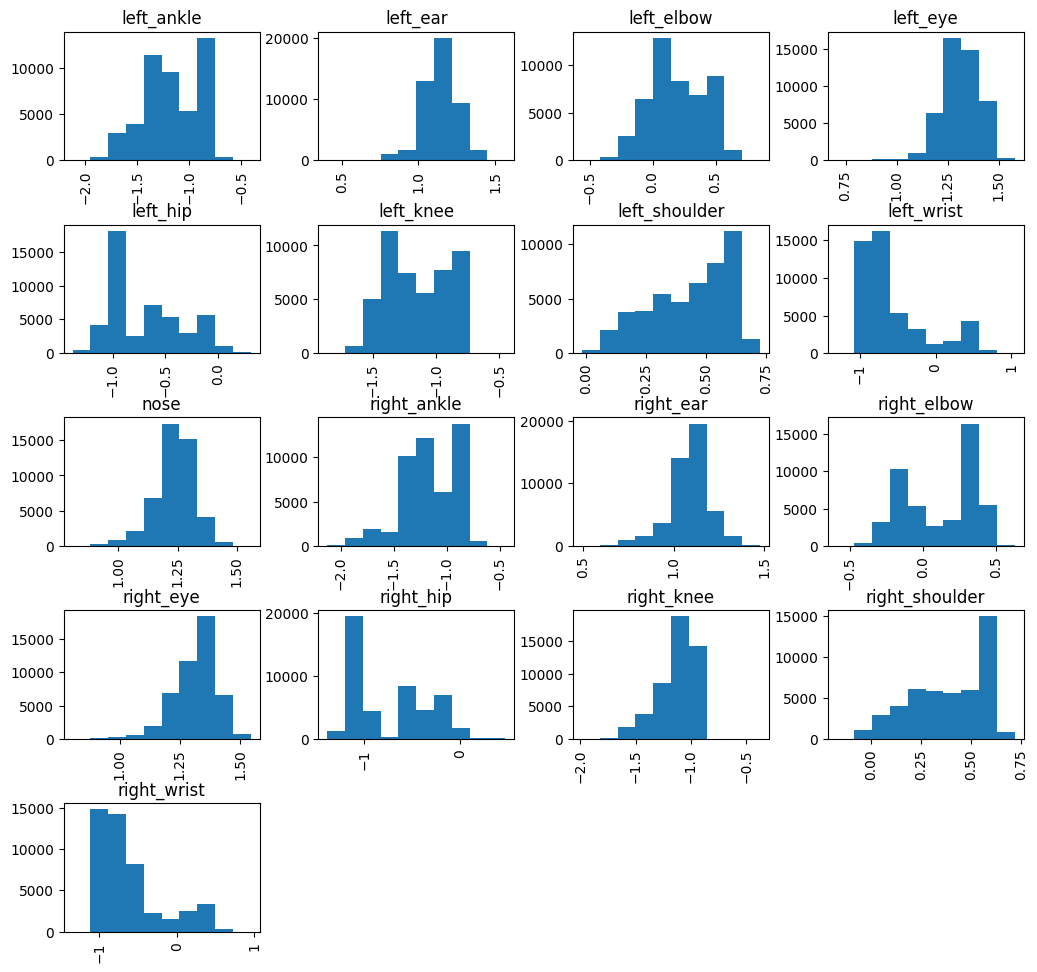

In [62]:
_ = points_df.hist('norm_score', by='point', figsize=(12, 12))

In [63]:
l = []
for video, video_df in points_df.groupby('video'):
    break

In [64]:
a = video_df[['frame_id', 'dx', 'dy', 'norm_score', 'point']].sort_values('frame_id').reset_index(drop=True).copy()
a

,frame_id,dx,dy,norm_score,point
0,0,0.000000,0.000000,-1.306062,left_ankle
1,0,0.000000,0.000000,-0.423248,right_wrist
2,0,0.000000,0.000000,0.344081,right_shoulder
3,0,0.000000,0.000000,-1.334841,right_knee
4,0,0.000000,0.000000,-0.603285,right_hip
...,...,...,...,...,...
5877,345,-0.000296,-0.000214,1.090618,left_ear
5878,345,0.000685,0.000627,-1.305285,left_ankle
5879,345,-0.000465,-0.000347,0.301347,right_shoulder
5880,345,-0.001126,0.000627,-0.300773,left_wrist


In [65]:
tab = pd.pivot_table(a, index='frame_id', columns='point', values=['dx', 'dy', 'norm_score'])
tab.shape

(346, 51)

In [66]:
tab.head()

dx                                                     \
point    left_ankle  left_ear left_elbow  left_eye  left_hip left_knee   
frame_id                                                                 
0          0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
1          0.000564  0.000611   0.000501  0.000639  0.000577  0.000571   
2          0.002623  0.000680  -0.000100  0.001578  0.000728  0.001676   
3          0.001430  0.006154   0.000446  0.006175  0.000504 -0.000439   
4          0.002082 -0.000779   0.002146  0.001069  0.003004  0.003949   

                                                         ... norm_score  \
point    left_shoulder left_wrist      nose right_ankle  ... left_wrist   
frame_id                                                 ...              
0             0.000000   0.000000  0.000000    0.000000  ...  -0.317239   
1             0.001469   0.000502  0.002530   -0.003002  ...  -0.287444   
2            -0.000144   0.000837  0.001554    0.000482  ...  -0.301867   
3             0.003281   0.000446  0.002439    0.002512  ...  -0.296929   
4            -0.000698   0.003084  0.002924    0.001888  ...  -0.250619   

                                                                          \
point         nose right_ankle right_ear right_elbow right_eye right_hip   
frame_id                                                                   
0         1.195349   -1.327910  0.967236    0.333853  1.326898 -0.603285   
1         1.203717   -1.324690  0.994605    0.352305  1.308350 -0.586739   
2         1.247309   -1.311569  1.034034    0.316235  1.297887 -0.588870   
3         1.277783   -1.294653  1.038882    0.304320  1.348590 -0.560197   
4         1.277163   -1.322659  0.996943    0.304308  1.345546 -0.507337   

                                                
point    right_knee right_shoulder right_wrist  
frame_id                                        
0         -1.334841       0.344081   -0.423248  
1         -1.340264       0.343761   -0.468796  
2         -1.330805       0.353030   -0.406803  
3         -1.314281       0.336473   -0.447701  
4         -1.408085       0.298860   -0.359413  

[5 rows x 51 columns]

In [70]:
# 3D tensor
np.stack((tab['dx'], tab['dy'], tab['norm_score'])).shape

(3, 346, 17)

In [82]:
4 * 25 *3

300

### Keyponts preprocessing for ImageBind

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns


In [7]:
point_filter = ['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist']

In [12]:
points_df = pd.read_csv('avatar_key_points.csv').drop(columns='Unnamed: 0')
points_df = points_df[points_df.point.isin(point_filter)]

# Normalize coordinates

points_df['x'] = points_df['x'] / points_df.width
points_df['y'] = points_df['y'] / points_df.height


points_df.head()

,video,frame_id,point,x,y,score,height,width
0,C9180/videos/talk01.mp4,0,nose,0.515052,0.244938,17.898088,480,640
1,C9180/videos/talk01.mp4,0,left_eye,0.562828,0.208711,19.173992,480,640
2,C9180/videos/talk01.mp4,0,right_eye,0.468213,0.202465,18.679369,480,640
3,C9180/videos/talk01.mp4,0,left_ear,0.618098,0.279916,18.796972,480,640
4,C9180/videos/talk01.mp4,0,right_ear,0.401701,0.276168,18.769829,480,640


In [20]:
l = []
for video, video_df in points_df.groupby('video'):
    for point, point_df in video_df.groupby('point'):
        point_df = point_df.sort_values('frame_id')
        point_df['shift_x'] = point_df.x.shift(-1)
        point_df['shift_y'] = point_df.y.shift(-1)
        point_df = point_df.dropna()
        l.append(point_df)
points_df = pd.concat(l)
points_df.head()

,video,frame_id,point,x,y,score,height,width,shift_x,shift_y
509867,Arvid/videos/talk_neutral_01.mp4,0,left_ear,0.560357,0.225369,17.295616,480,640,0.560968,0.227238
509884,Arvid/videos/talk_neutral_01.mp4,1,left_ear,0.560968,0.227238,17.070618,480,640,0.561647,0.229489
509901,Arvid/videos/talk_neutral_01.mp4,2,left_ear,0.561647,0.229489,17.210846,480,640,0.567802,0.227155
509918,Arvid/videos/talk_neutral_01.mp4,3,left_ear,0.567802,0.227155,17.429781,480,640,0.567022,0.225721
509935,Arvid/videos/talk_neutral_01.mp4,4,left_ear,0.567022,0.225721,16.993832,480,640,0.569539,0.225506


In [81]:
video_keypoints_dst = {}

for video, video_df in points_df.groupby('video'):
    M = []
    for frame_id, frame_df in video_df.groupby('frame_id'):
        frame_df = frame_df.sort_values('point')
        # pairwise distances between key points on current frame
        m = pairwise_distances(frame_df[['x', 'y']].values, frame_df[['x', 'y']].values)
        # pairwise distances between key points on next frame
        m_next = pairwise_distances(frame_df[['shift_x', 'shift_y']].values, frame_df[['shift_x', 'shift_y']].values)
        # delta
        dm = m_next - m 
        M.append(dm.flatten())

    M = np.vstack(M)
    video_keypoints_dst[video] = np.vstack(M)

In [130]:
def convet_to_imu(m):
    """ IMU input for ImageBind model 6 x 2000
        in this case I take into account first 4 seconds of video with fps 25 (4 * 25) and for convinience I get rid off last column(distances to right_wrist)
    """
    n_rows = 100
    _m = m[:n_rows, :-1]
    dr = n_rows - len(_m)
    b = torch.from_numpy(_m.astype('float32'))
    if dr > 0:
        b = torch.nn.functional.pad(b, (0, 0, 0, dr), mode='constant', value=0)
    imu = torch.stack([b[:, :20].flatten(), b[:, 20:40].flatten(), b[:, 40:60].flatten(), b[:, 60:80].flatten(), b[:, 80:100].flatten(), b[:, 100:].flatten()])
    return imu

In [ ]:
device = 'cuda' 
model.to(device)

In [132]:
video_imu = {}

for i in tqdm(video_keypoints_dst):
    m = video_keypoints_dst[i]
    imu = convet_to_imu(m)
    imu_batch  = torch.unsqueeze(imu, 0)

    inputs = {
        ModalityType.IMU: imu_batch.to(device)
    }

    with torch.no_grad():
        imu_emb= model(inputs)

    video_imu[i] = imu_emb['imu'].cpu().numpy()

100%|██████████| 326/326 [00:01<00:00, 187.04it/s]


### Clusters for imu-key_points vectors

In [138]:
df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')

In [137]:
imu_labels = []
imu_embs = []

for k, v in video_imu.items():
    imu_labels.append(k)
    imu_embs.append(v)

imu_embs = np.vstack(imu_embs)
imu_embs.shape

(326, 1024)

In [142]:
# Some videos from avatar dataset were broken, that why we need to sync videos and embs 

ds = pd.DataFrame()
ds['path'] = imu_labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.shape

(326, 7)

In [140]:
# Resize images for cluster visualization in bokeh
base = '/home/vash/apps/avatar/avatar_studio/db'

imgs = []
for i in tqdm(imu_labels):
    video_path = os.path.join(base, i)
    cap = cv2.VideoCapture(video_path)
    while(cap.isOpened()):
        ret,img = cap.read()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        break
    imgs.append(img)
    cap.release()

100%|██████████| 326/326 [00:33<00:00,  9.80it/s]


In [144]:
ds.vcls.value_counts()

vcls
talk                     142
talking neutral           51
talking happy             30
general                   25
talking interrogative     16
talking persuasive        16
affirmative               12
talking sorry             11
negative                   8
talk pause                 7
agreement                  2
cross                      1
hands                      1
helpless                   1
dance                      1
shy                        1
sorry                      1
Name: count, dtype: int64

In [143]:
_labels = ds.vcls.values

In [146]:
thumb_size = 96
plot_size = 800

# bokeh umap visualization
projector(imu_embs, labels=_labels, images=imgs, image_size=thumb_size, plot_size=plot_size, save_file=False)

perfoming projection using UMAP


generating diplayabe images: 100%|██████████| 326/326 [00:00<00:00, 1834.28it/s]


Loading BokehJS ...

Loading BokehJS ...

In [148]:
reducer = umap.UMAP(densmap=True)
cords = reducer.fit_transform(imu_embs)
_idxs = list(range(len(imu_embs)))

class_list = sorted(set(_labels))
num_classes = len(class_list)

# generate data
data = dict(
    id=_idxs,
    x=[i[0] for i in cords],
    y=[i[1] for i in cords],
    labels=_labels,
)

data = pd.DataFrame.from_dict(data)

<Axes: xlabel='x', ylabel='y'>

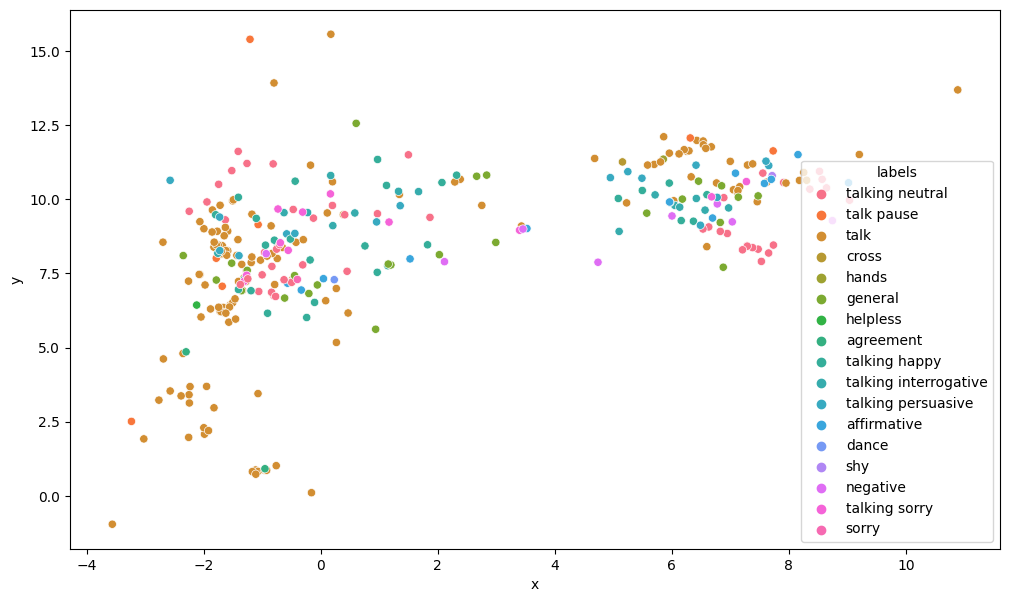

In [149]:
fig = plt.figure(figsize=(12, 7))
sns.scatterplot(data, x='x', y='y', hue='labels')

## Key points (mmpose: whole bodey, 133 points)

In [ ]:
# /home/vash/apps/avatar/mmpose/GetLandmarks.ipynb

In [27]:
import pickle
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import cv2

from PIL import Image, ImageDraw
from sklearn.metrics import pairwise_distances

import os

In [13]:
from projector import projector

In [28]:
def preproc_text_labels(ds):
    
    gender_map = {
              'Arvid': 'man', 
              'Bizdev': 'man',
              'C9175': 'man',
              'C9176': 'woman',
              'C9180': 'woman',
              'C9183': 'man',
              'C9186': 'man',
              'C9187': 'woman',
              'C9188': 'man',
              'Jessica': 'woman',
              'Mia': 'woman',
              'Nick': 'man',
              'Vlad': 'man',
              'Yao': 'man',
              }
    
    ds['gender'] = ds.folder.apply(lambda x: gender_map[x])
    ds['vcls'] = ds.vcls.apply(lambda x: x.replace('_', ' ').strip())
    ds['vcls'] = ds.vcls.apply(lambda x: re.sub('talk ', 'talking ', x))
    ds.loc[ds.vcls == 'pause', 'vcls'] = 'talk pause'
    ds.loc[ds.vcls == 'yes', 'vcls'] = 'agreement'
    ds.loc[ds.vcls == 'ok', 'vcls'] = 'agreement'

    def get_sentence(r):
        return f"{r[0]} {r[1]}"
    
    ds['sentence'] = ds[['gender', 'vcls']].apply(get_sentence, axis=1)
    return ds

In [29]:
base = '/home/vash/apps/avatar/avatar_studio/db'

df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')

with open('/home/vash/apps/avatar/ImageBind-LoRA/avatar_labels.pickl', 'rb') as f:
    labels = pickle.load(f)

ds = pd.DataFrame()
ds['path'] = labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


In [30]:
## Read points info for Avatar Dataset

with open('/home/vash/apps/avatar/mmpose/wholebody_points_scaled.pckl', 'rb') as f:
    points = pickle.load(f)

points[0]

{'video': 'C9180/videos/talk01.mp4',
 'frame_id': 0,
 'kpts': array([[ 279.41938162,  130.54232419],
        [ 307.1850729 ,  112.85087585],
        [ 253.79790187,  110.92416465],
        [ 337.37615168,  146.10224783],
        [ 223.32092643,  140.66905797],
        [ 413.95362139,  310.78481197],
        [ 137.36513972,  301.93282485],
        [ 432.92794347,  510.0386095 ],
        [ 108.32986504,  507.10947633],
        [ 384.7777319 ,  571.24012828],
        [ 124.36657816,  566.42593861],
        [ 342.90477455,  587.41057634],
        [ 188.29613149,  583.24891448],
        [ 332.62220442,  487.40205288],
        [ 198.65018249,  479.67541337],
        [ 317.78400958,  529.16662216],
        [ 316.53782845,  529.17949677],
        [ 217.95540869,   68.32068086],
        [ 216.54885828,   68.73355329],
        [ 527.21558332, -145.19103907],
        [ 320.06490648,   74.75358367],
        [ 322.32136846,   74.8114121 ],
        [  13.74698102, -142.35227622],
        [ 224.71224

### show me points

In [31]:
## Test, visualization
v = points[0]['video']
kpts = points[0]['kpts']
scores = points[0]['scores']

video_path = os.path.join(base, v)
cap = cv2.VideoCapture(video_path)
frame_no = 0
cap.set(1,frame_no)
ret, frame = cap.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

h, w, _ = frame.shape
scale_h = int(h/2)
scale_w = int(w/2)

img = cv2.resize(frame, (scale_w, scale_h))
img = Image.fromarray(img)

cap.release()

canvas_width = img.size[0]
canvas_height = img.size[1] + 200
new_img = Image.new('RGB', (canvas_width, canvas_height), (128, 128, 128))
new_img.paste(img)
draw = ImageDraw.Draw(new_img)

In [32]:
key_point_ids = [0,1,2,3,4,5,6,7,8,9,10,42,47,71,74,77]

d = 4
for i in key_point_ids:
     p = kpts[i]
     s = scores[i]
     if s > 0.1:
          xy = [p[0]-d, p[1]-d, p[0]+d, p[1]+d]
          draw.rounded_rectangle(xy = xy,
                    fill = "yellow",
                    outline = (255, 255, 255),
                    width = 3)
          draw.text(p-d, str(i), fill='black')
     else:
          print(f'Point: {i}, score: {s}')

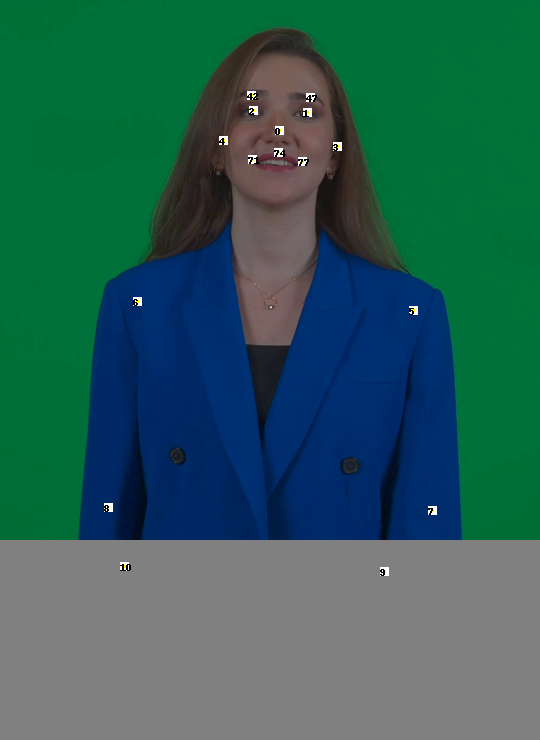

In [33]:
new_img

### Preprocessing foi ImageBind model like IMU input

In [34]:
key_point_ids = [0,1,2,3,4,5,6,7,8,9,10,42,47,71,74,77]

key_points_label_map = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    42: 'right_eyebrow',
    47: 'left_eyebrow',
    71: 'right_mouth',
    74: 'center_mouth',
    77: 'left_mouth'
}

In [35]:
len(key_point_ids)

16

In [36]:
# video	frame_id	point	x	y	score	height	width
scale_ratio = 2

l = []
for p in points:
    video = p['video']
    frame_id = p['frame_id']
    height = p['height']
    width = p['width']
    for p_id in key_point_ids:
        x, y = p['kpts'][p_id]
        l.append({'video': video, 
                  'frame_id': frame_id, 
                  'point': key_points_label_map[p_id],
                  'height': height, 
                  'width': width, 
                  'x': x, 
                  'y': y,
                  'scale': scale_ratio})
len(l)

802384

In [37]:
# Normalize coordinates
points_df = pd.DataFrame(l)
points_df['x'] = points_df['x'] / (points_df.width / scale_ratio)
points_df['y'] = points_df['y'] / (points_df.height / scale_ratio)


points_df.head()

,video,frame_id,point,height,width,x,y,scale
0,C9180/videos/talk01.mp4,0,nose,1080,1080,0.517443,0.241745,2
1,C9180/videos/talk01.mp4,0,left_eye,1080,1080,0.568861,0.208983,2
2,C9180/videos/talk01.mp4,0,right_eye,1080,1080,0.469996,0.205415,2
3,C9180/videos/talk01.mp4,0,left_ear,1080,1080,0.624771,0.270560,2
4,C9180/videos/talk01.mp4,0,right_ear,1080,1080,0.413557,0.260498,2


In [38]:
l = []
for video, video_df in points_df.groupby('video'):
    for point, point_df in video_df.groupby('point'):
        point_df = point_df.sort_values('frame_id')
        point_df['shift_x'] = point_df.x.shift(-1)
        point_df['shift_y'] = point_df.y.shift(-1)
        point_df = point_df.dropna()
        l.append(point_df)
points_df = pd.concat(l)
points_df.head()

,video,frame_id,point,height,width,x,y,scale,shift_x,shift_y
508190,Arvid/videos/talk_neutral_01.mp4,0,center_mouth,1080,1500,0.494803,0.278039,2,0.495537,0.280426
508206,Arvid/videos/talk_neutral_01.mp4,1,center_mouth,1080,1500,0.495537,0.280426,2,0.496552,0.282748
508222,Arvid/videos/talk_neutral_01.mp4,2,center_mouth,1080,1500,0.496552,0.282748,2,0.502023,0.286497
508238,Arvid/videos/talk_neutral_01.mp4,3,center_mouth,1080,1500,0.502023,0.286497,2,0.503274,0.286479
508254,Arvid/videos/talk_neutral_01.mp4,4,center_mouth,1080,1500,0.503274,0.286479,2,0.507573,0.284855


In [15]:
video_keypoints_dst = {}

for video, video_df in points_df.groupby('video'):
    M = []
    for frame_id, frame_df in video_df.groupby('frame_id'):
        frame_df = frame_df.sort_values('point')
        # pairwise distances between key points on current frame
        m = pairwise_distances(frame_df[['x', 'y']].values, frame_df[['x', 'y']].values)
        # pairwise distances between key points on next frame
        m_next = pairwise_distances(frame_df[['shift_x', 'shift_y']].values, frame_df[['shift_x', 'shift_y']].values)
        
        # delta
        dm = m_next - m
        # get upper triangle without diagonal # after that shape will be (120, 0)
        tri_ids = np.triu_indices_from(dm, k=1)

        M.append(dm[tri_ids])

    M = np.vstack(M)
    video_keypoints_dst[video] = np.vstack(M)

In [16]:
def points_to_imu(m):
    """ IMU input for ImageBind model 6 x 2000
        in this case I take into account first 4 seconds of video with fps 25 (4 * 25) and for convinience I get rid off last column(distances to right_wrist)
    """
    n_rows = 100
    _m = m[:n_rows] # !
    dr = n_rows - len(_m)
    b = torch.from_numpy(_m.astype('float32'))
    if dr > 0:
        b = torch.nn.functional.pad(b, (0, 0, 0, dr), mode='constant', value=0)
    imu = torch.stack([b[:, :20].flatten(), b[:, 20:40].flatten(), b[:, 40:60].flatten(), b[:, 60:80].flatten(), b[:, 80:100].flatten(), b[:, 100:].flatten()])
    return imu

In [24]:
device = 'cuda' 
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [25]:
video_imu = {}

for i in tqdm(video_keypoints_dst):
    m = video_keypoints_dst[i]
    imu = points_to_imu(m)

    imu_batch  = torch.unsqueeze(imu, 0)

    inputs = {
        ModalityType.IMU: imu_batch.to(device)
    }

    with torch.no_grad():
        imu_emb= model(inputs)

    video_imu[i] = imu_emb['imu'].cpu().numpy()

100%|██████████| 326/326 [00:01<00:00, 203.95it/s]


In [35]:
with open('video_imu_16.pickl', 'wb') as f:
    pickle.dump(video_imu, f)

### Clusters for imu vectors

In [26]:
imu_labels = []
imu_embs = []

for k, v in video_imu.items():
    imu_labels.append(k)
    imu_embs.append(v)

imu_embs = np.vstack(imu_embs)
imu_embs.shape

(326, 1024)

In [27]:
# Resize images for cluster visualization in bokeh
base = '/home/vash/apps/avatar/avatar_studio/db'

imgs = []
for i in tqdm(imu_labels):
    video_path = os.path.join(base, i)
    cap = cv2.VideoCapture(video_path)
    while(cap.isOpened()):
        ret,img = cap.read()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        break
    imgs.append(img)
    cap.release()

100%|██████████| 326/326 [00:33<00:00,  9.75it/s]


In [28]:
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


In [29]:
_ds = pd.DataFrame()
_ds['path'] = imu_labels
_ds = _ds.merge(ds, on='path', how='left')

_ds.shape

(326, 7)

In [30]:
_ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,Arvid/videos/talk_neutral_01.mp4,Arvid,talk_neutral_01,14.68,talking neutral,man,man talking neutral
1,Arvid/videos/talk_neutral_02.mp4,Arvid,talk_neutral_02,15.72,talking neutral,man,man talking neutral
2,Arvid/videos/talk_neutral_03.mp4,Arvid,talk_neutral_03,14.08,talking neutral,man,man talking neutral
3,Arvid/videos/talk_neutral_04.mp4,Arvid,talk_neutral_04,12.44,talking neutral,man,man talking neutral
4,Arvid/videos/talk_neutral_05.mp4,Arvid,talk_neutral_05,10.96,talking neutral,man,man talking neutral


In [31]:
_labels = _ds.vcls.values

In [33]:
thumb_size = 96
plot_size = 800

# bokeh umap visualization
projector(imu_embs, labels=_labels, images=imgs, image_size=thumb_size, plot_size=plot_size, save_file=False)

perfoming projection using UMAP


generating diplayabe images: 100%|██████████| 326/326 [00:00<00:00, 1834.42it/s]


Loading BokehJS ...

Loading BokehJS ...

## Clusters for videos with the same actor

In [23]:
import seaborn as sns
import umap  # umap-learn==0.5.3
from distinctipy import distinctipy   # distinctipy==1.2.2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

from tqdm import tqdm
import os
import cv2

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
base = '/home/vash/apps/avatar/avatar_studio/db'

df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')

with open('avatar_embs.npy', 'rb') as f:
    EMBS = np.load(f)

with open('/home/vash/apps/avatar/ImageBind-LoRA/avatar_labels.pickl', 'rb') as f:
    labels = pickle.load(f)

ds = pd.DataFrame()
ds['path'] = labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


In [25]:
# Resize images for cluster visualization in bokeh
base = '/home/vash/apps/avatar/avatar_studio/db'

imgs = []
for i in tqdm(labels):
    video_path = os.path.join(base, i)
    cap = cv2.VideoCapture(video_path)
    while(cap.isOpened()):
        ret,img = cap.read()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        break
    imgs.append(img)
    cap.release()

with open('imgs.pckl', 'wb') as f:
    pickle.dump(imgs, f)

100%|██████████| 326/326 [00:33<00:00,  9.59it/s]


In [30]:
ds.groupby(['folder'])['vcls'].nunique().sort_values(ascending=False).head(7)

folder
Mia        8
Nick       8
Vlad       7
C9188      7
Jessica    6
Yao        5
C9187      4
Name: vcls, dtype: int64

In [31]:
ds[ds.folder == 'Mia'].groupby('vcls')['path'].count()

vcls
affirmative              3
general                  5
negative                 3
talking happy            5
talking interrogative    3
talking neutral          5
talking persuasive       2
talking sorry            3
Name: path, dtype: int64

In [32]:
ds[ds.folder == 'Nick'].groupby('vcls')['path'].count()

vcls
affirmative              3
general                  6
negative                 2
talking happy            9
talking interrogative    5
talking neutral          6
talking persuasive       6
talking sorry            5
Name: path, dtype: int64

In [33]:
ds[ds.folder == 'Vlad'].groupby('vcls')['path'].count()

vcls
general                  5
sorry                    1
talking happy            5
talking interrogative    3
talking neutral          5
talking persuasive       3
talking sorry            3
Name: path, dtype: int64

In [7]:
def plot_actor_clusters(actor_df, EMBS, text_labels=False):
    
    embs = EMBS[actor_df.index]
    _labels = actor_df.vcls.values

    reducer = umap.UMAP(densmap=True)
    cords = reducer.fit_transform(embs)
    _idxs = list(range(len(embs)))

    class_list = sorted(set(_labels))
    num_classes = len(class_list)

    # generate data
    data = dict(
        id=_idxs,
        x=[i[0] for i in cords],
        y=[i[1] for i in cords],
        labels=_labels,
    )

    fig = plt.figure(figsize=(7, 7))
    sns.scatterplot(data, x='x', y='y', hue='labels', style='labels')

    if text_labels:
        for i, label in enumerate (data['labels']):
            plt.text(data['x'][i]+0.05, data['y'][i]+0.05, label, size='x-small', alpha=0.5)

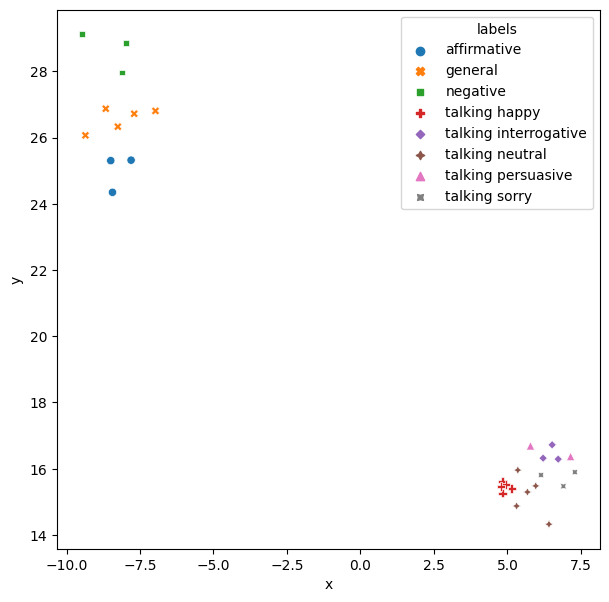

In [64]:
actor = 'Mia'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, EMBS, text_labels=False)

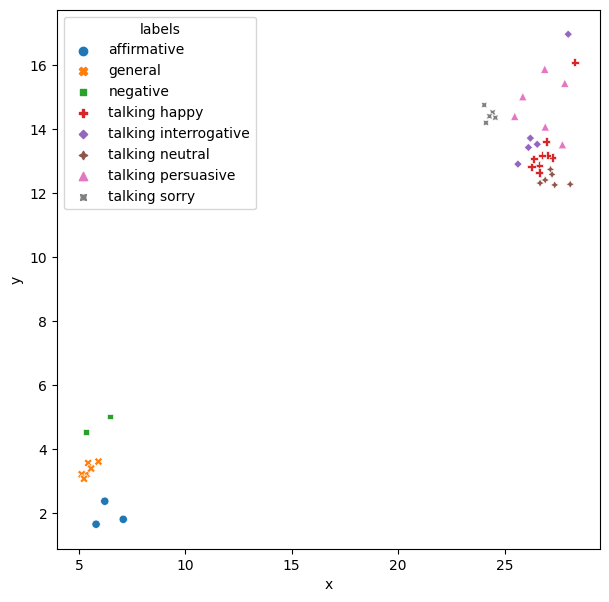

In [65]:
actor = 'Nick'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, EMBS, text_labels=False)

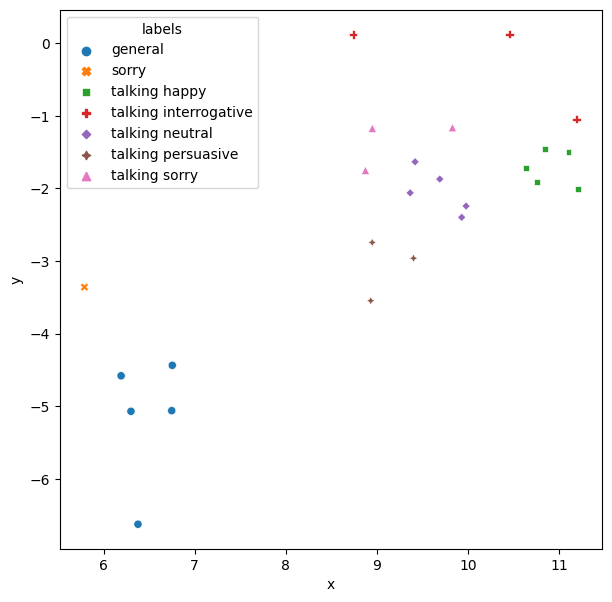

In [66]:
actor = 'Vlad'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, EMBS, text_labels=False)

## Video embs, original ImageBind

In [5]:
base = '/home/vash/apps/avatar/avatar_studio/db'

df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')

with open('/home/vash/apps/avatar/original_imagebind/ImageBind/avatar_embs_original.npy', 'rb') as f:
    EMBS = np.load(f)

with open('/home/vash/apps/avatar/original_imagebind/ImageBind/avatar_original.pickl', 'rb') as f:
    labels = pickle.load(f)

ds = pd.DataFrame()
ds['path'] = labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.head()

/tmp/ipykernel_48509/2089539814.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f"{r[0]} {r[1]}"


,path,folder,video_type,duration,vcls,gender,sentence
0,C9180/videos/talk01.mp4,C9180,talk01,4.56,talk,woman,woman talk
1,C9180/videos/talk02.mp4,C9180,talk02,3.80,talk,woman,woman talk
2,C9180/videos/talk03.mp4,C9180,talk03,5.16,talk,woman,woman talk
3,C9180/videos/talk04.mp4,C9180,talk04,2.08,talk,woman,woman talk
4,C9180/videos/talk05.mp4,C9180,talk05,2.40,talk,woman,woman talk


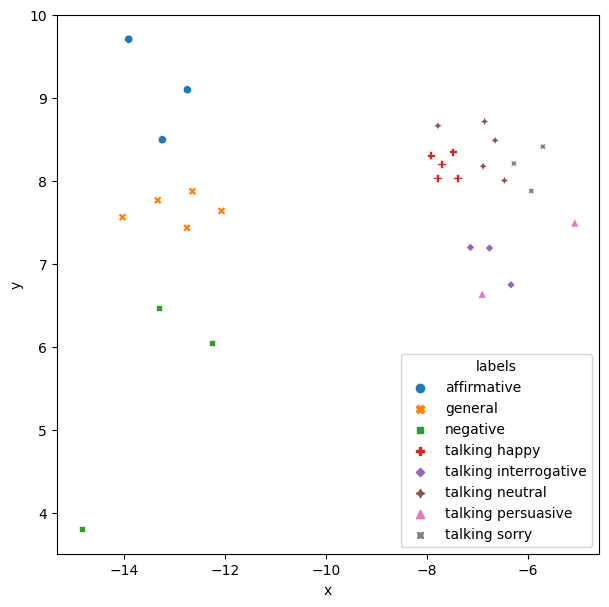

In [12]:
actor = 'Mia'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, EMBS, text_labels=False)

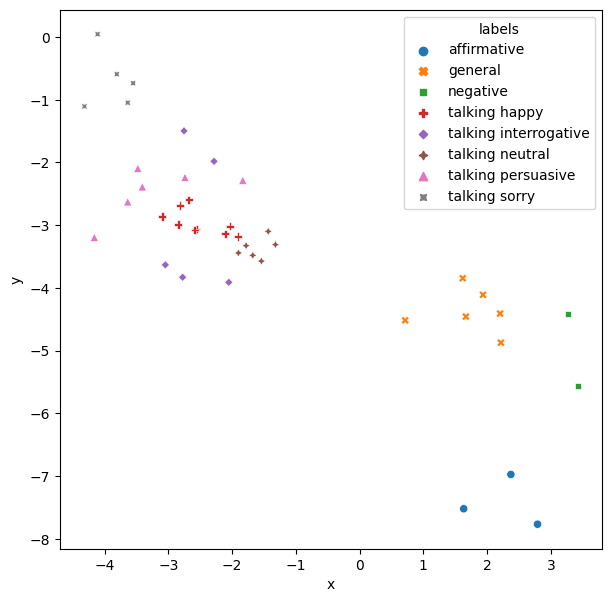

In [13]:
actor = 'Nick'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, EMBS, text_labels=False)

### The same for keypoints-imu

####  ImageBind, key points to vector

In [18]:
with open('video_imu_16.pickl', 'rb') as f:
    video_imu = pickle.load(f)
len(video_imu)

326

In [19]:
imu_labels = []
imu_embs = []

for k, v in video_imu.items():
    imu_labels.append(k)
    imu_embs.append(v)

imu_embs = np.vstack(imu_embs)
imu_embs.shape

(326, 1024)

In [21]:
base = '/home/vash/apps/avatar/avatar_studio/db'

df = pd.read_csv('/home/vash/apps/avatar/gesture_clustering/avatar_ds.csv')


ds = pd.DataFrame()
ds['path'] = imu_labels
ds = ds.merge(df, on='path', how='left')
ds = preproc_text_labels(ds)
ds.head()

,path,folder,video_type,duration,vcls,gender,sentence
0,Arvid/videos/talk_neutral_01.mp4,Arvid,talk_neutral_01,14.68,talking neutral,man,man talking neutral
1,Arvid/videos/talk_neutral_02.mp4,Arvid,talk_neutral_02,15.72,talking neutral,man,man talking neutral
2,Arvid/videos/talk_neutral_03.mp4,Arvid,talk_neutral_03,14.08,talking neutral,man,man talking neutral
3,Arvid/videos/talk_neutral_04.mp4,Arvid,talk_neutral_04,12.44,talking neutral,man,man talking neutral
4,Arvid/videos/talk_neutral_05.mp4,Arvid,talk_neutral_05,10.96,talking neutral,man,man talking neutral


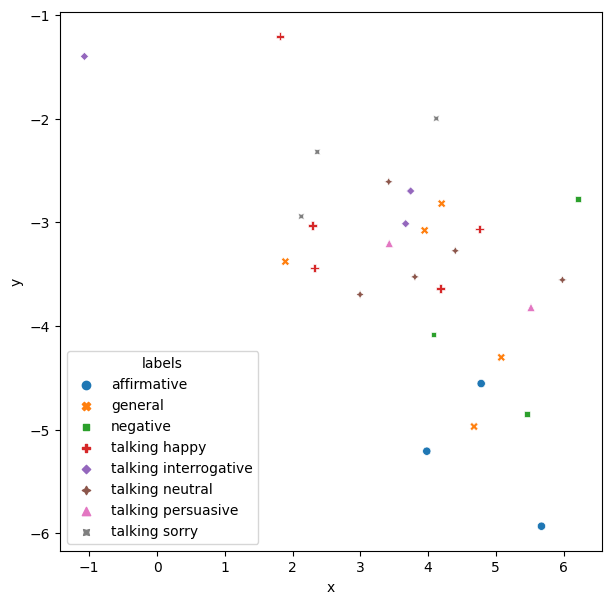

In [22]:
actor = 'Mia'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, imu_embs, text_labels=False)

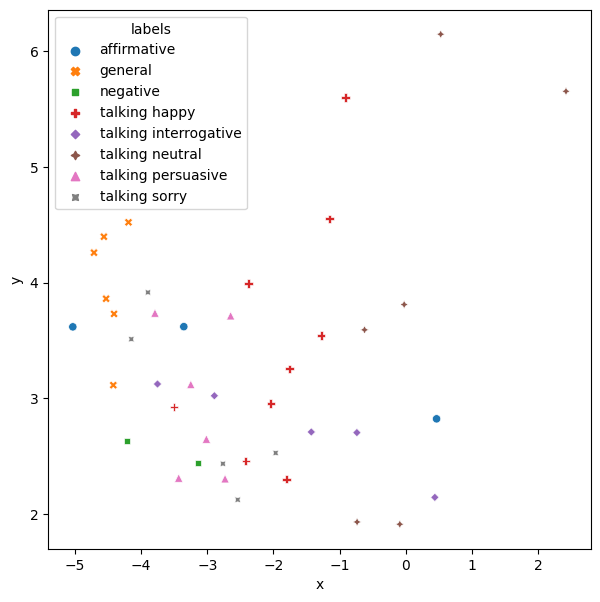

In [23]:
actor = 'Nick'
actor_df = ds[ds.folder == actor]

plot_actor_clusters(actor_df, imu_embs, text_labels=False)

#### Normalized key points vector

In [39]:
points_df.head()

,video,frame_id,point,height,width,x,y,scale,shift_x,shift_y
508190,Arvid/videos/talk_neutral_01.mp4,0,center_mouth,1080,1500,0.494803,0.278039,2,0.495537,0.280426
508206,Arvid/videos/talk_neutral_01.mp4,1,center_mouth,1080,1500,0.495537,0.280426,2,0.496552,0.282748
508222,Arvid/videos/talk_neutral_01.mp4,2,center_mouth,1080,1500,0.496552,0.282748,2,0.502023,0.286497
508238,Arvid/videos/talk_neutral_01.mp4,3,center_mouth,1080,1500,0.502023,0.286497,2,0.503274,0.286479
508254,Arvid/videos/talk_neutral_01.mp4,4,center_mouth,1080,1500,0.503274,0.286479,2,0.507573,0.284855


In [ ]:
# ?

## Video visualisation

In [ ]:
# player = 'WER10'
# fname = '255_0_48779_49028.mp4'
# _v_path = os.path.join(base, player, 'clips', fname)
# Video(_v_path)

In [ ]:
# html_str=""

# for filepath in filepaths:
#   mp4 = open(filepath,'rb').read()
#   data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#   html_str += """
#   <video width=224 controls>
#         <source src="%s" type="video/mp4">
#   </video>
#   """ % data_url
# HTML(html_str)

In [ ]:
# find similar videos by imu to imus vector similarity
# k = 7

# imu_dst = metrics.pairwise_distances(imu, train_imu_embs, metric='cosine')
# topk_ids = imu_dst.argsort()[0][:k]
# topk = {i:v for i,v in zip(topk_ids, imu_dst[0][topk_ids])}

# filepaths = []

# for i in topk:
#     player = train_ds[train_ds.ind == i].player.item()
#     fname = train_ds[train_ds.ind == i].video.item()
#     v_path = os.path.join(base, player, 'clips', fname)
#     filepaths.append(v_path)

# print(topk)

# html_str=""

# for filepath in filepaths:
#   mp4 = open(filepath,'rb').read()
#   data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#   html_str += """
#   <video width=224 controls>
#         <source src="%s" type="video/mp4">
#   </video>
#   """ % data_url
# HTML(html_str)